This is a notebook for the **Week 2 of the Developer Challenge: https://blogs.sap.com/2023/03/08/sap-community-developer-challenge-eda-with-sap-hana-and-python/**

Some code might be incomplete or incorrect. It is your task to fix it and execute the whole notebook receiving correct results.

Submit the link to your solution: https://groups.community.sap.com/t5/application-development/submissions-for-quot-eda-with-sap-hana-quot-developer-challenge/m-p/224446/highlight/true#M1129

## Initialize the notebook

Import required packages

In [1]:
from hana_ml import dataframe as hdf
import pandas as pd

Connect to SAP HANA database instance with a database user, same as during Week 1!

In [2]:
myconn=hdf.ConnectionContext(userkey='DevChallenger')
print("SAP HANA DB version: ", myconn.hana_version())

SAP HANA DB version:  4.00.000.00.1679990881 (fa/CE2023.4)


In [3]:
print(myconn.sql("SELECT NOW() FROM DUMMY").collect().CURRENT_TIMESTAMP[0])

2023-04-06 09:30:03.748000


# Working with SAP HANA tables in a Python client 

Below you will find two approaches creating tables, populating them with data and retrieving this data from Python:
1. Compatible with Python standard proposal PEP 249 using SQL
2. Using HANA DataFrame abstract from `hana_ml`

## 1. Approach compatible with Python proposal PEP 249 using SQL

References:
1. https://peps.python.org/pep-0249/#connection-objects
2. https://help.sap.com/docs/SAP_HANA_CLIENT/f1b440ded6144a54ada97ff95dac7adf/3b5ebe388c1040ec83617c9e511ecda5.html?version=2.15&locale=en-US

`ConnectionContext` in `hana-ml` represents a connection to a SAP HANA database instance.

It has [an attribute `connection`](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2022_4_QRC/en-US/hana_ml.dataframe.html#hana_ml.dataframe.ConnectionContext) which is the underlying dbapi connection from [SAP HANA Client's Python driver `hdbcli`](https://help.sap.com/docs/SAP_HANA_CLIENT/f1b440ded6144a54ada97ff95dac7adf/d12c86af7cb442d1b9f8520e2aba7758.html?version=2.15&locale=en-US).

Let's open a [cursor](https://help.sap.com/docs/SAP_HANA_CLIENT/f1b440ded6144a54ada97ff95dac7adf/d0c010fa5c4e4e4cba7b791cd1c9479b.html?version=2.15&locale=en-US) called `mycursor` to be used for the fetch operations.

In [4]:
mycursor = myconn.connection.cursor()

[Execute an SQL statement](https://help.sap.com/docs/SAP_HANA_CLIENT/f1b440ded6144a54ada97ff95dac7adf/3b89755ceec042e5919313b40acf8794.html?version=2.15&locale=en-US) to create a table `SEASONS` in the database.

In [6]:
#mycursor.execute('DROP TABLE "SEASONS"'); #uncomment to drop the table, if already exists

mycursor.execute('''
CREATE TABLE "SEASONS" (
  "ID" INT PRIMARY KEY, 
  "DESC" VARCHAR(12)
)
''');

Use [SQL statement to insert multiple records](https://help.sap.com/docs/SAP_HANA_CLIENT/f1b440ded6144a54ada97ff95dac7adf/15e46b843c8045ec854d6375790cd504.html?version=2.15&locale=en-US) into the table `SEASONS`.

You should get the following result after execurting the cell below:
```
Records inserted:  4
```

In [7]:
mycursor.execute('TRUNCATE TABLE "SEASONS"');

records_inserted=mycursor.executemany(operation='INSERT INTO "SEASONS" ("ID", "DESC") VALUES (?, ?)',
                                     list_of_parameters=
                                      ((1, "WINTER"),
                                      (2, "SPRING"),
                                      (3, "SUMMER"),
                                      (4, "FALL"))
                                     )
print("Records inserted: ", sum(records_inserted))

Records inserted:  4


Use SQL statement to fetch all records from the table

You should get:
```
the first record (1, 'WINTER')
the second record (2, 'SPRING')
the rest of records [(3, 'SUMMER'), (4, 'FALL')]
```

In [8]:
mycursor.execute('SELECT * FROM "SEASONS"')
#Get the first record
result=mycursor.fetchone()
print("the first record", result)

#Get the second record
result=mycursor.fetchone()
print("the second record", result)

#Get the rest of records
result=mycursor.fetchall()
print("the rest of records", result)

the first record (1, 'WINTER')
the second record (2, 'SPRING')
the rest of records [(3, 'SUMMER'), (4, 'FALL')]


### Let's check tables created so far in the current database schema.

In [9]:
print(f"Current database schema: {myconn.get_current_schema()}")

Current database schema: DEVCHALLENGER


In [13]:
mycursor.execute(f'''
SELECT TABLE_NAME
FROM M_TABLES
WHERE SCHEMA_NAME='{myconn.get_current_schema()}'
''')

#Get all records
result=mycursor.fetchall()
print(f"{len(result)} table(s) in the schema {myconn.get_current_schema()}: {[x[0] for x in result]}")

1 table(s) in the schema DEVCHALLENGER: ['SEASONS']


# 2. `hana-ml` approach using interoperability between Pandas DataFrames and HANA DataFrames

References:
1. https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2022_4_QRC/en-US/hana_ml.html#sap-hana-dataframe
1. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

Create a table `MONTHS` in the current database schema.

But this time you should use [`create_table()` method](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2022_4_QRC/en-US/hana_ml.dataframe.html#hana_ml.dataframe.ConnectionContext.create_table) from `hana_ml`.

In [14]:
# myconn.drop_table("MONTHS")
myconn.create_table("MONTHS", table_structure={"ID":"INT", "DESC":"VARCHAR(10)"})

Check tables created so far in the current database schema.

But this time you should use [`get_tables()` method](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2022_4_QRC/en-US/hana_ml.dataframe.html#hana_ml.dataframe.ConnectionContext.get_tables) from `hana_ml` to receive the output similar to:

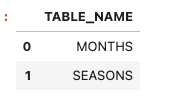

In [15]:
myconn.get_tables()

,TABLE_NAME
0,MONTHS
1,SEASONS


Create [Pandas DataFrame](https://pandas.pydata.org/docs/getting_started/intro_tutorials/01_table_oriented.html#what-kind-of-data-does-pandas-handle) with data describing calendar months. 

The name of the object is `months_df`, and it is quite common to use `_df` postfix in a name of a variable storing Pandas DataFrame.

In [16]:
months_df=pd.DataFrame(
    {"ID": range(1,13),
     "DESC": ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    })

Display data from Pandas DataFrame `months_df`. 
> For the clarity of the output `.style.hide(axis='index')` can be added to remove the Pandas index from the output.

In [17]:
display(months_df)

# compare the output with a hidden Pandas index by removing a comment in the line below: 
display(months_df.style.hide(axis='index'))

,ID,DESC
0,1,JAN
1,2,FEB
2,3,MAR
3,4,APR
4,5,MAY
5,6,JUN
6,7,JUL
7,8,AUG
8,9,SEP
9,10,OCT


ID,DESC
1,JAN
2,FEB
3,MAR
4,APR
5,MAY
6,JUN
7,JUL
8,AUG
9,SEP
10,OCT


## Create HANA DataFrame from Pandas DataFrame.

`hana_ml` provides a [method `create_dataframe_from_pandas`](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2022_4_QRC/en-US/hana_ml.dataframe.html#hana_ml.dataframe.create_dataframe_from_pandas) to store data from the Pandas DataFrame in a table in SAP HANA database. A table is created, if needed.

The name of the object is `months_hdf`, and it is quite common to use `_hdf` postfix in a name of a variable storing HANA DataFrame.

In [19]:
months_hdf = hdf.create_dataframe_from_pandas(connection_context=myconn,
                                      pandas_df=months_df,
                                      table_name='MONTHS',
                                      primary_key='ID',
                                      force=True
                                     )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.26it/s]


The type of a `months_hdf` object returned from the `create_dataframe_from_pandas` method is a HANA DataFrame (`hana_ml.dataframe.DataFrame`)...

In [20]:
type(months_hdf)

hana_ml.dataframe.DataFrame


HANA DataFrames do not store any data on a client side in Python. Each HANA DataFrame only stores a connection contex and a [`select_statement` attribute](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2022_4_QRC/en-US/hana_ml.dataframe.html#hana_ml.dataframe.DataFrame) to be used to retrieve data from the SAP HANA database.

In [21]:
print(months_hdf.select_statement)

SELECT * FROM "MONTHS"


You can, obviously, use that SELECT statement **to retrieve data using SQL** as you've seen in the first approach...

In [22]:
mycursor.execute(months_hdf.select_statement)

#Get all records
result=mycursor.fetchall()

#Display returned records
print(f"All {len(result)} records: {result}")

All 12 records: [(1, 'JAN'), (2, 'FEB'), (3, 'MAR'), (4, 'APR'), (5, 'MAY'), (6, 'JUN'), (7, 'JUL'), (8, 'AUG'), (9, 'SEP'), (10, 'OCT'), (11, 'NOV'), (12, 'DEC')]


...but **the proper way to retrieve data** from a HANA table is by using a [`collect` method](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2022_4_QRC/en-US/hana_ml.dataframe.html#hana_ml.dataframe.DataFrame.collect), which returns selected data in the form of the Pandas DataFrame.

In [23]:
months_hdf.collect()

,ID,DESC
0,1,JAN
1,2,FEB
2,3,MAR
3,4,APR
4,5,MAY
5,6,JUN
6,7,JUL
7,8,AUG
8,9,SEP
9,10,OCT


You can see this method returns an instance of a Pandas DataFrame (`pandas.core.frame.DataFrame`).

In [25]:
type(months_hdf.collect())

pandas.core.frame.DataFrame

## Using `hana-ml` approach to load data from a CSV file (or any other file Pandas can read)

In most of the case we do not want to manually type data to be inserted, but have this data already stored in a file, like CSV.

In [26]:
url="https://raw.githubusercontent.com/SAP-samples/hana-ml-samples/main/Python-API/pal/datasets/bike.csv"
bikes_df = pd.io.parsers.read_csv(url)

Display the content of the Pandas DataFrame `bikes_df` with data from the CSV file.

In [27]:
display(bikes_df)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4
...,...,...,...,...,...,...,...,...,...,...,...,...
726,WINTER,2012,DEC,NO HOLIDAY,THU,WORKING DAY,MISTY,3.945849,65.2917,23.458911,2114,726
727,WINTER,2012,DEC,NO HOLIDAY,FRI,WORKING DAY,MISTY,3.906651,59.0000,10.416557,3095,727
728,WINTER,2012,DEC,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,3.906651,75.2917,8.333661,1341,728
729,WINTER,2012,DEC,NO HOLIDAY,SUN,NO WORKING DAY,GOOD,4.024151,48.3333,23.500518,1796,729


Now persist this data in HANA table database using the same [`create_dataframe_from_pandas` method](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2022_4_QRC/en-US/hana_ml.dataframe.html#hana_ml.dataframe.create_dataframe_from_pandas) from `hana_ml` as before.

In [29]:
bikes_hdf = hdf.create_dataframe_from_pandas(connection_context=myconn,
                                      pandas_df=bikes_df,
                                      table_name='BIKES',
                                      primary_key='days_since_2011',
                                      force=True
                                     )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


The type of a `bikes_hdf` object returned from the `create_dataframe_from_pandas` method is a HANA DataFrame...

In [30]:
type(bikes_hdf)

hana_ml.dataframe.DataFrame

...and a SELECT statement that supports this HANA DataFrame

In [33]:
print(bikes_hdf.select_statement)

SELECT * FROM "BIKES"


As stated above the `collect()` method returns a Pandas DataFrame, and therefore Pandas methods can be applied to it, like `head()` to output a few records...

In [34]:
bikes_hdf.collect().head(n=10)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4
5,WINTER,2011,JAN,NO HOLIDAY,THU,WORKING DAY,GOOD,1.604356,51.8261,6.000868,1606,5
6,WINTER,2011,JAN,NO HOLIDAY,FRI,WORKING DAY,MISTY,1.236534,49.8696,11.304642,1510,6
7,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,-0.245000,53.5833,17.875868,959,7
8,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,GOOD,-1.498349,43.4167,24.250650,822,8
9,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,-0.910849,48.2917,14.958889,1321,9


...or `["season"].unique().tolist()` to output [unique values](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html#pandas.Series.unique) only from the `season` column [as a list](https://pandas.pydata.org/docs/reference/api/pandas.Series.tolist.html#pandas.Series.tolist).

In [35]:
bikes_hdf.collect()["season"].unique().tolist()

['WINTER', 'SPRING', 'SUMMER', 'FALL']

The problem with the above approach applying Pandas' data manipulation methods **after** `collect()` -- as in the two cells above -- is that they require **complete** set of data be transferred from a table in SAP HANA database to Python client before data manipulation is applied.

Next week you will work on applying data manipulation **before** `collect()` is executed, so that methods are pushed down to be executed in the SAP HANA database and **only results** are returned to the client!

### Stay tuned for the Week 3!